In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')

suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library("ggtree"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))
suppressPackageStartupMessages(library("ggpubr"))

quantDir <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/salmon_quants"
saveDir <- "environment/brain_sim_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees_updated_sim"
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep="_")))
                           
files <- file.path(quantDir, samples, "quant.sf")
coldata <- data.frame(files = files, names = samples, condition = as.factor(rep(c(1,2),each=6)))
clustFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
tseCons <- buildTSE(treeTermFile = clustFile, coldata = coldata)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)
termFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=1.4:2.8/post_type=gibbs_nrep=100_tf=100/terminus/old/1_1/clusters.txt"
                           
load("treeDE_Paper_Images/brain_sim_nodtu/detNodes.RData")
load("treeDE_Paper_Images/brain_sim_nodtu/negNodes.RData")

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3817

Aggregation Started

Aggregation Ended



In [2]:
load("/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/sim_expr.rda")
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))

missingTxps <- setdiff(treeCons$tip.label, rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[treeCons$tip.label,]
dts <- intersect(dts, rownames(sim.counts.mat))

innNodes <- l+1:treeCons$Nnode
aggCountsNodes <- computeAggNodesU(treeCons, c(1:length(treeCons$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])

### Transcript level DE

In [3]:
y <- fishpond::scaleInfReps(tseCons[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y,x="condition")

### For all the nodes in the tree

In [4]:
set.seed(10)
yA <- computeSizeFactors(tseCons)
yA <- scaleInfReps(yA)
yInn <- swish(yA[(l+1):nrow(tseCons),], x="condition")
mcols(yA)[["pvalue"]] <- c(mcols(y)[["pvalue"]], mcols(yInn)[["pvalue"]])
infReps <- fishpond:::getInfReps(yA)
lfc <- fishpond:::getLog2FC(infReps,condition=colData(yA)[["condition"]])
mcols(yA)[["log2FC"]] <- lfc

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

### Comparing treeDE with tcr

In [5]:
j <- 1
tcrTxps <- detNodes$treeClimbRO[[j]]
treeTermTxps <- unlist(Descendants(treeCons,detNodes$treeDEFDR_OL[[j]]))
tcrN <- detNodes$treeClimbR[[j]]
treeTermN <- detNodes$treeDEFDR_OL[[j]]
paste(length(tcrTxps), length(treeTermTxps)) ##nodes and txps
paste(length(tcrN),length(treeTermN)) ##nodes and txps

[1] "6731 7257"

[1] "3791 5072"

#### Height distribution

In [6]:
sapply(seq(3), function(i) table(node.depth(treeCons, 2)[detNodes$treeDEFDR_OL[[i]]]))
sapply(seq(3), function(i) table(node.depth(treeCons, 2)[detNodes$treeClimbR[[i]]]))

[[1]]

   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
4013  554  256  125   62   28   12    9    4    4    1    2    1    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
5186  626  283  129   61   31   11    8    6    4    2    1    1    1 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
5904  654  286  136   61   28   10    8    7    5    2    3    1 


[[1]]

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2914  326  164  116   80   57   38   28   15   14   13    5    5    6    4    1 
  17   18   19 
   3    1    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2941  379  176  140  117   73   52   50   40   26   29    8   12   14    7    4 
  17   18   19   20   21   24   25   29 
   4    3    2    1    1    2    1    2 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2996  434  200  159  125   98   68   50   45   30   32   13   15   15    9    8 
  17   18   19   20   21   22   24   25   29 
   6    6    2    1    1    2    3    1    2 


In [152]:
compFdratEffSizes <- function(nodes) {
    effSizes <- sort(abs(mcols(yA)[nodes, "log2FC"]), decreasing = T)
    fdrs <- c()
    ls <- c()
    for(i in seq(effSizes)){
        rNodes <- nodes[abs(mcols(yA)[nodes, "log2FC"]) >= effSizes[i]]
        ls <- c(ls, length(rNodes))
        fdrs <- c(fdrs,sum(abs(logFCNodes[rNodes]) < rootFC)/length(rNodes))
    }
    return(list("fdrs"=fdrs, "lengths"=ls, "effSizes"=effSizes, nodes=rNodes))
}
plotScatPlot <- function(vals, size=20) {
    df <- data.frame(vals)
    pFDR <- ggplot(df, aes(x=effSizes,y=fdrs)) +
        geom_point() +
        xlab("Absolute LFC") +
        ylab("FDR") +
        theme_bw() +
        theme(text=element_text(size=size))
#         ggtitle(paste("Unique nodes obtained at FDR", nFDR, "for", type))
    
    pL <- ggplot(df, aes(x=effSizes,y=lengths)) +
        geom_point() +
        xlab("Absolute LFC") +
        ylab("Number of nodes") +
        theme_bw() +
        theme(text=element_text(size=size))
#         ggtitle(paste("Unique nodes obtained at FDR", nFDR, "for", type))
    
    pp <- ggarrange(pFDR, pL, common.legend = T)
    pp
}

#### Nodes unique to each

In [153]:
vals <- list()
vals[["tt"]] <- list()
vals[["tcr"]] <- list()
for(j in seq(3)) {
    print(paste("For the FDR", c(0.01,0.05,0.1)[j]))
    tcrTxps <- detNodes$treeClimbRO[[j]]
    treeTermTxps <- unlist(Descendants(treeCons,detNodes$treeDEFDR_OL[[j]]))
    tcrN <- detNodes$treeClimbR[[j]]
    treeTermN <- detNodes$treeDEFDR_OL[[j]]
#     print(paste(length(tcrTxps), length(treeTermTxps)))
#     print(paste(length(tcrN),length(treeTermN)))
    
#     print(paste("Common Node", sum(treeTermN %in% tcrN)) ##common nodes)
    remTTNodes <- setdiff(treeTermN, tcrN)
#     print(paste("Nodes unique to treeTerm",length(remTTNodes)))

    remTCR <- setdiff(tcrN, treeTermN)
#     print(paste("Nodes unique to treeClimbR", length(remTCR)))

    ancRemTT <- Ancestors(treeCons, remTTNodes)
    treeDENodesAncTcr <- remTTNodes[sapply(ancRemTT, function(anc) sum(anc %in% tcrN) > 0)]
    ancRemtreeDENodes <- sapply(ancRemTT[match(treeDENodesAncTcr, remTTNodes)], function(anc) anc[anc %in% tcrN]) ##Corresponding ancestor of treeDE in TCR
#     print(paste("Unique nodes in treeTerm that have a node in tcr as an ancestor", length(treeDENodesAncTcr)))

    ancRemTCR <- Ancestors(treeCons, remTCR)
    tcrNodesAncTreeDE <- remTCR[sapply(ancRemTCR, function(anc) sum(anc %in% treeTermN) > 0)]
    ancRemtcrNodes <- sapply(ancRemTCR[match(tcrNodesAncTreeDE, remTCR)], function(anc) anc[anc %in% treeTermN]) ##Corresponding ancestor of TCR in treeDE
#     print(paste("Unique nodes in tcr that have a node in treeTerm as an ancestor", length(tcrNodesAncTreeDE))) ## Ancestors in treeDE (overaggregation here)
                             
    nodesOnlyTT <- setdiff(remTTNodes,c(treeDENodesAncTcr,ancRemtcrNodes)) ## the second part contains nodes that have descendants
    print(paste("Length of only TT nodes", length(nodesOnlyTT)))
    print(paste("FDR of only TT nodes", mean(abs(logFCNodes[c(nodesOnlyTT)]) < rootFC)))
    vals[["tt"]][[j]] <- compFdratEffSizes(nodesOnlyTT)
    nodesOnlyTCR <- setdiff(remTCR,c(tcrNodesAncTreeDE,ancRemtreeDENodes)) ## the second part contains nodes that have descendants
    print(paste("Length of only TCR nodes", length(nodesOnlyTCR)))
    print(paste("FDR of only TCR nodes", mean(abs(logFCNodes[c(nodesOnlyTCR)]) < rootFC)))
    vals[["tcr"]][[j]] <- compFdratEffSizes(nodesOnlyTCR)         
}


[1] "For the FDR 0.01"
[1] "Length of only TT nodes 199"
[1] "FDR of only TT nodes 0.085427135678392"
[1] "Length of only TCR nodes 2"
[1] "FDR of only TCR nodes 0"
[1] "For the FDR 0.05"
[1] "Length of only TT nodes 308"
[1] "FDR of only TT nodes 0.412337662337662"
[1] "Length of only TCR nodes 4"
[1] "FDR of only TCR nodes 0"
[1] "For the FDR 0.1"
[1] "Length of only TT nodes 381"
[1] "FDR of only TT nodes 0.606299212598425"
[1] "Length of only TCR nodes 4"
[1] "FDR of only TCR nodes 0.25"


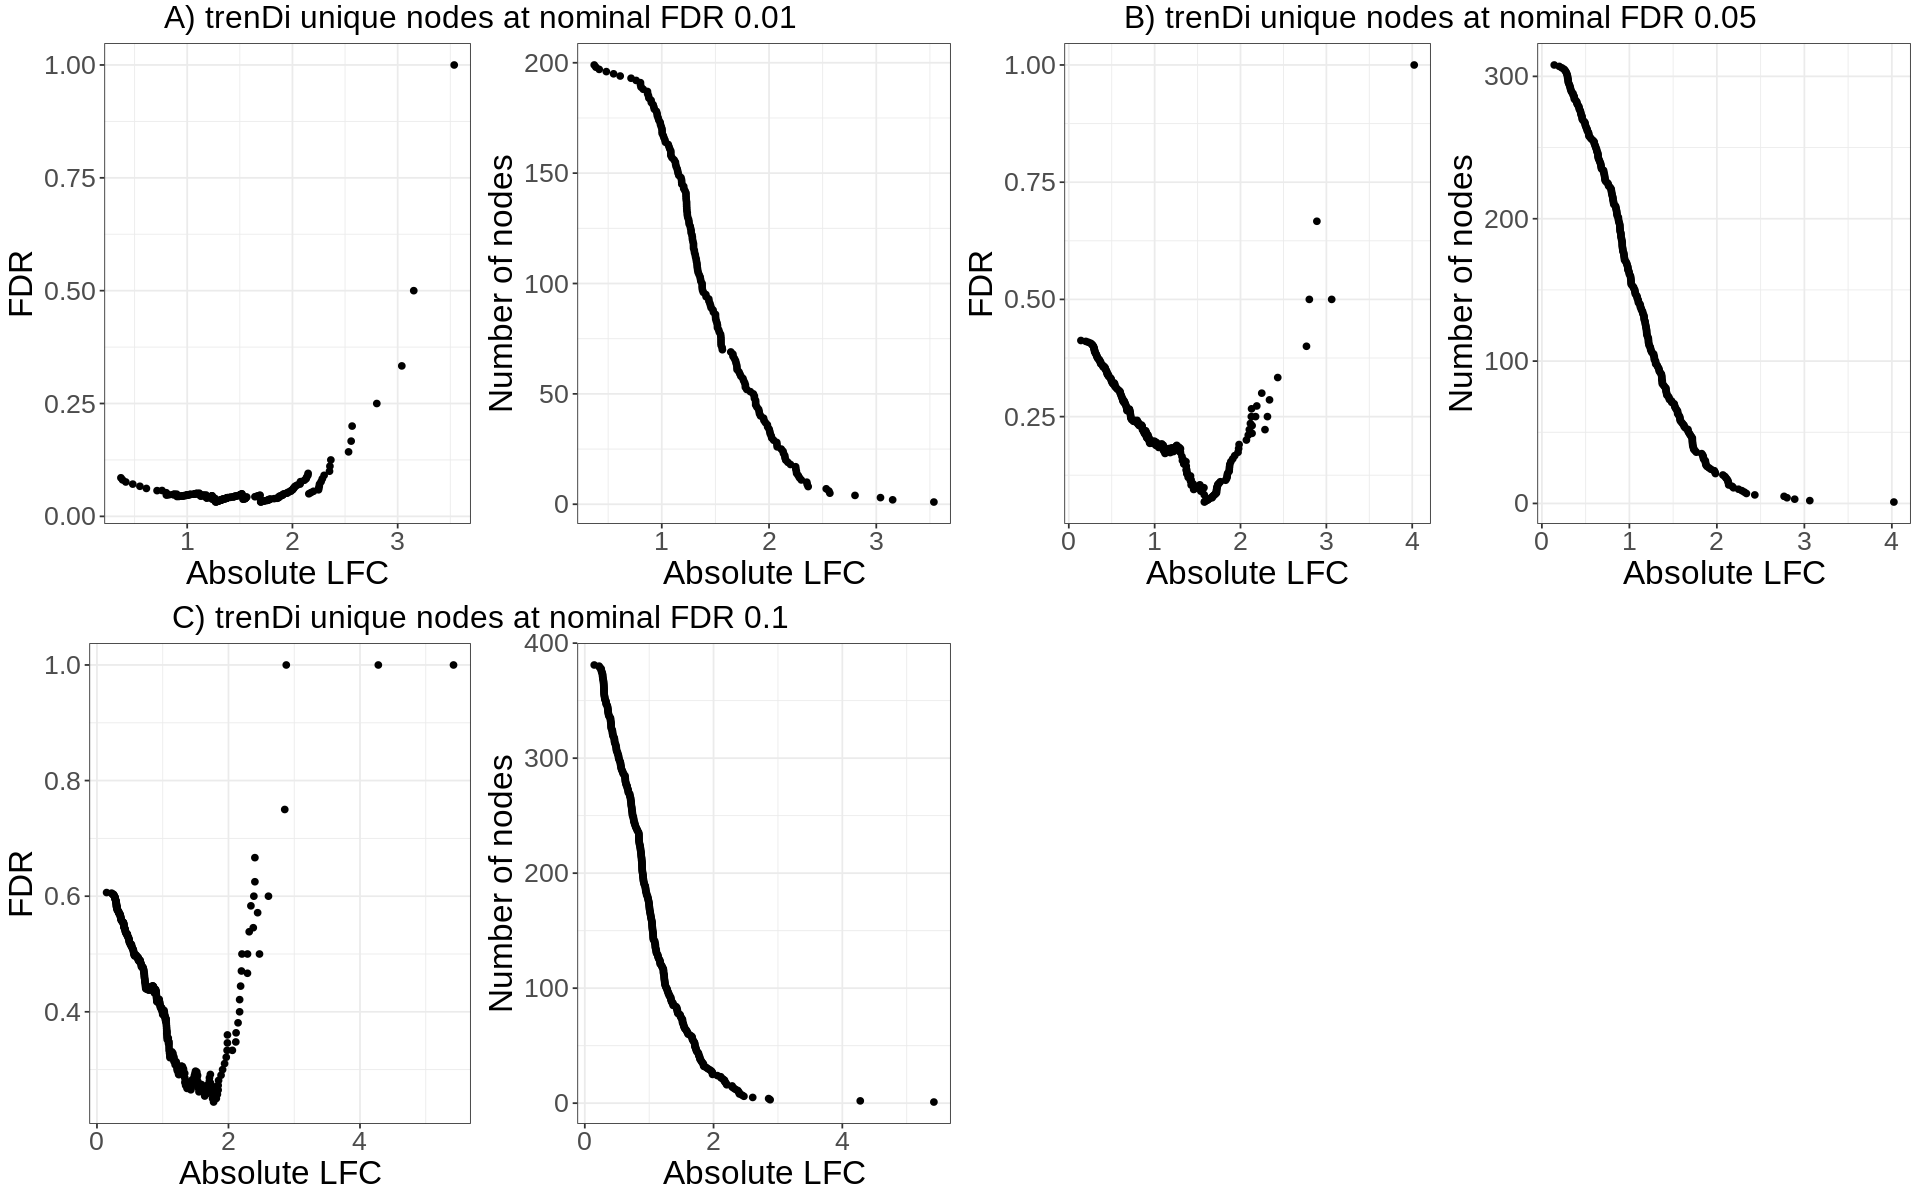

In [217]:
options(repr.plot.width=16, repr.plot.height=10)
p1 <- annotate_figure(plotScatPlot(vals$tt[[1]]), top=text_grob("A) trenDi unique nodes at nominal FDR 0.01", size=19))
p2 <- annotate_figure(plotScatPlot(vals$tt[[2]]), top=text_grob("B) trenDi unique nodes at nominal FDR 0.05", size=19))
p3 <- annotate_figure(plotScatPlot(vals$tt[[3]]), top=text_grob("C) trenDi unique nodes at nominal FDR 0.1", size=19))
ggarrange(p1,p2,p3)

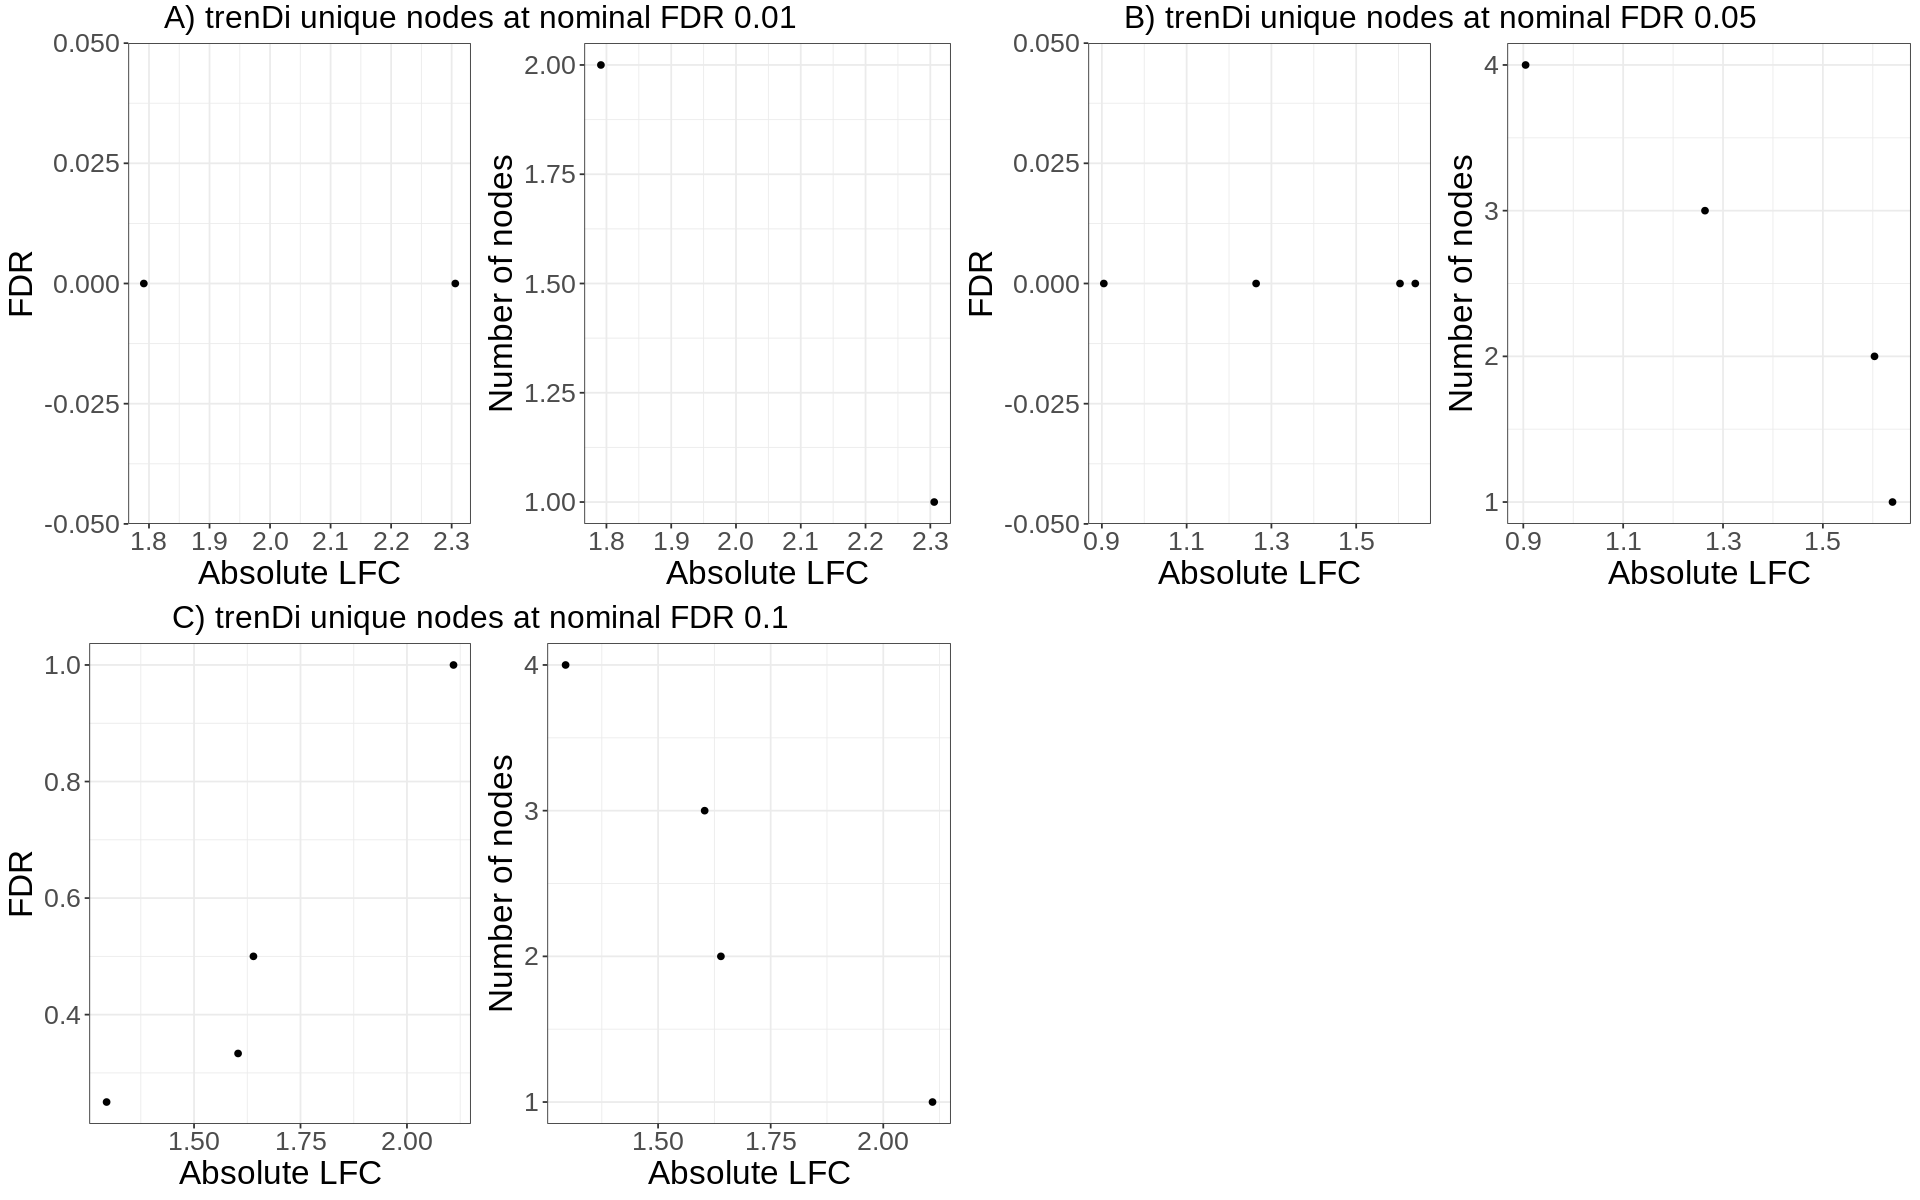

In [218]:
options(repr.plot.width=16, repr.plot.height=10)
p1 <- annotate_figure(plotScatPlot(vals$tcr[[1]]), top=text_grob("A) treeClimbR unique nodes at nominal FDR 0.01", size=19))
p2 <- annotate_figure(plotScatPlot(vals$tcr[[2]]), top=text_grob("B) treeClimbR unique nodes at nominal FDR 0.05", size=19))
p3 <- annotate_figure(plotScatPlot(vals$tcr[[3]]), top=text_grob("C) treeClimbR unique nodes at nominal FDR 0.1", size=19))
ggarrange(p1,p2,p3)

#### Txp with TCR comparison

In [220]:
vals <- list()
for(j in seq(3)) {
    txpN <- detNodes[["Txps"]][[j]]
    tcrN <- detNodes[["treeClimbR"]][[j]]
    remTCR <- setdiff(tcrN, txpN)

    remTxp <- setdiff(txpN, tcrN)

    ancRem <- Ancestors(treeCons, remTxp)
    txpAncTCR <- remTxp[sapply(ancRem, function(anc) sum(anc %in% tcrN) > 0)]

    descTcr <- Descendants(treeCons, remTCR)
    descRemTcrNodes <- remTCR[sapply(descTcr, function(desc) sum(desc %in% txpN) > 0)]

    mTxps <- setdiff(remTxp, c(txpAncTCR))
    print(paste("Length of only txps", length(mTxps)))
    print(paste("FDR of only txp", mean(abs(logFCNodes[mTxps]) < rootFC)))
    vals[["txp"]][[j]] <- compFdratEffSizes(mTxps)
    
    mTCR <- setdiff(remTCR, descRemTcrNodes)
    print(paste("Length of only TCR nodes", length(mTCR)))
    print(paste("FDR of only TCR nodes", mean(abs(logFCNodes[mTCR]) < rootFC)))
    vals[["tcr"]][[j]] <- compFdratEffSizes(mTCR)
}


[1] "Length of only txps 145"
[1] "FDR of only txp 0.103448275862069"
[1] "Length of only TCR nodes 15"
[1] "FDR of only TCR nodes 0"
[1] "Length of only txps 255"
[1] "FDR of only txp 0.415686274509804"
[1] "Length of only TCR nodes 25"
[1] "FDR of only TCR nodes 0.24"
[1] "Length of only txps 339"
[1] "FDR of only txp 0.589970501474926"
[1] "Length of only TCR nodes 27"
[1] "FDR of only TCR nodes 0.481481481481481"


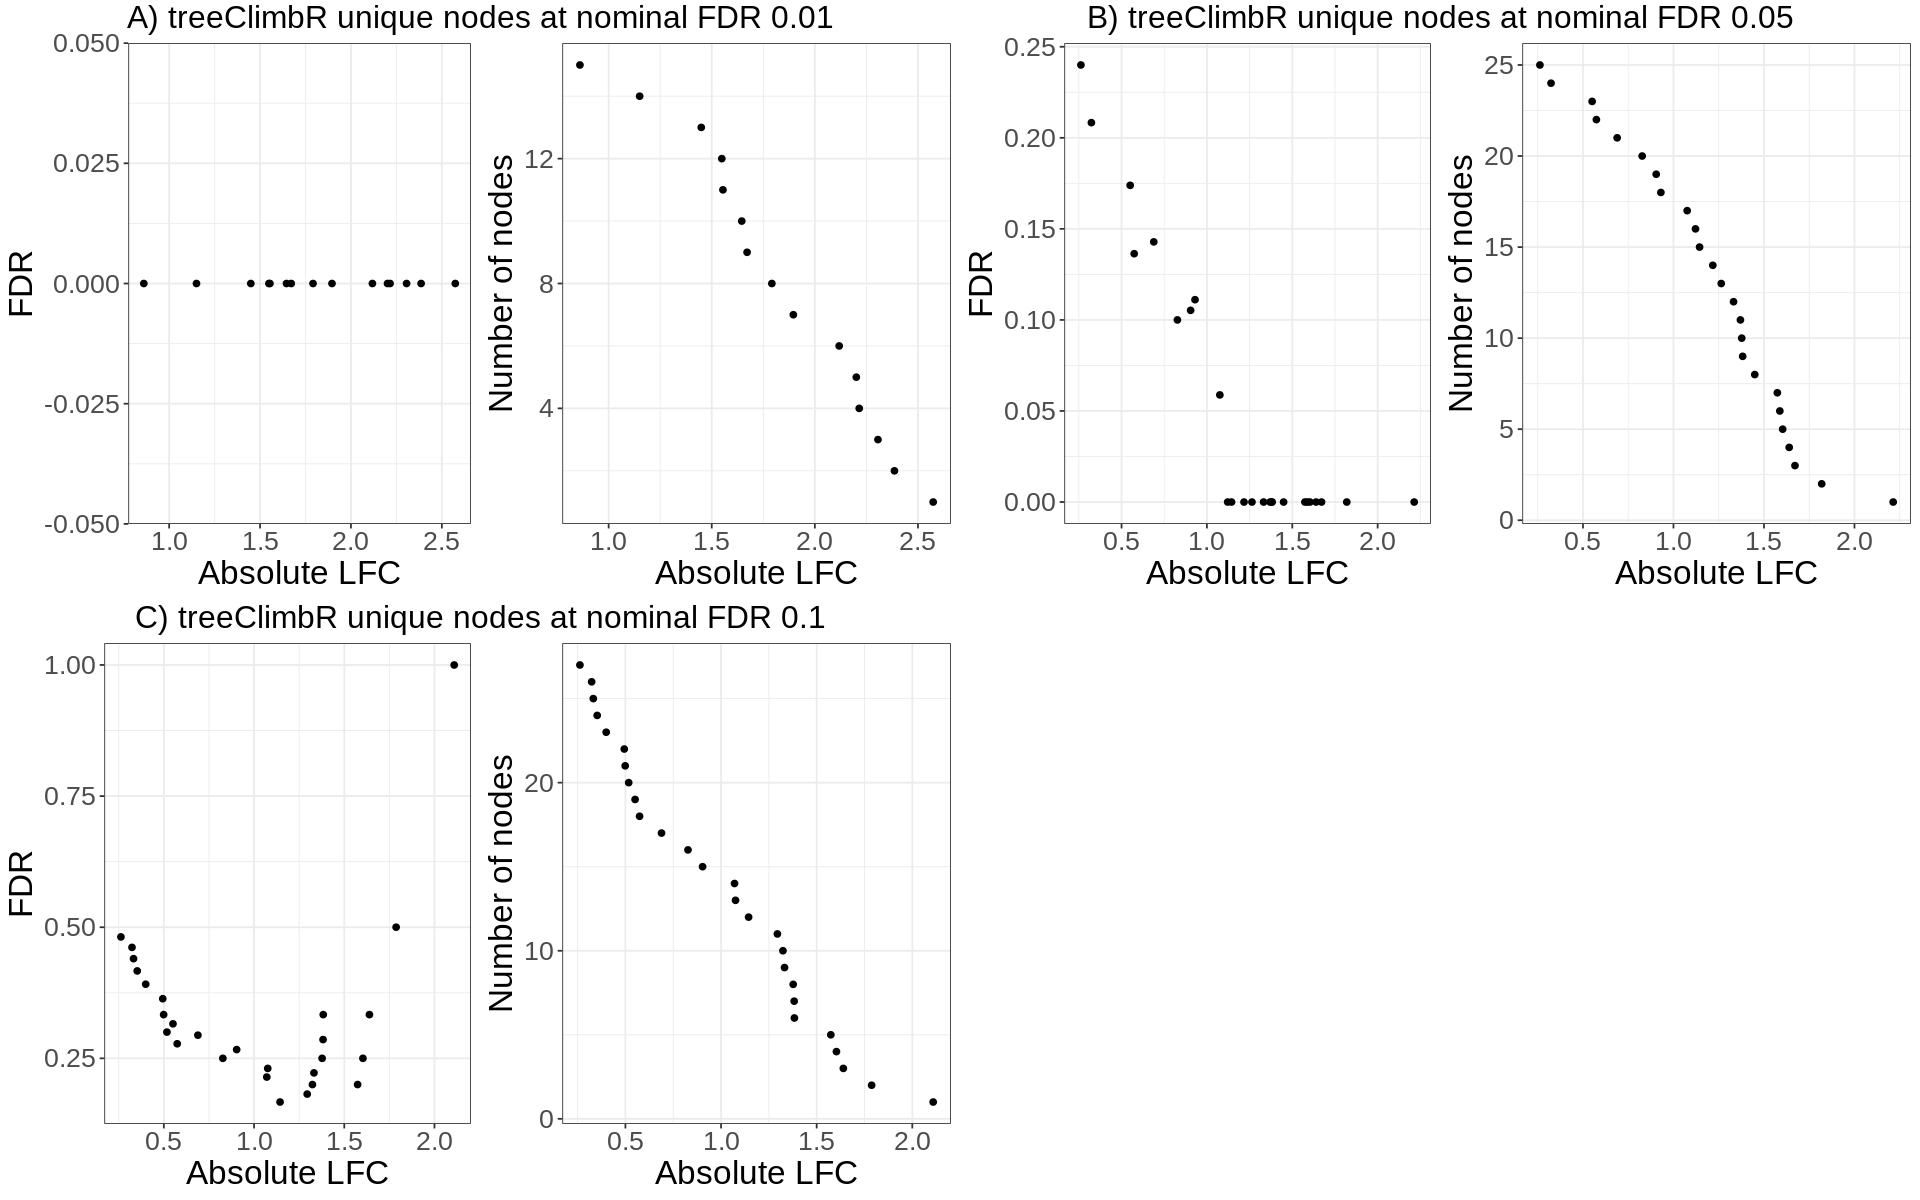

In [221]:
options(repr.plot.width=16, repr.plot.height=10)
p1 <- annotate_figure(plotScatPlot(vals$tcr[[1]]), top=text_grob("A) treeClimbR unique nodes at nominal FDR 0.01", size=19))
p2 <- annotate_figure(plotScatPlot(vals$tcr[[2]]), top=text_grob("B) treeClimbR unique nodes at nominal FDR 0.05", size=19))
p3 <- annotate_figure(plotScatPlot(vals$tcr[[3]]), top=text_grob("C) treeClimbR unique nodes at nominal FDR 0.1", size=19))
ggarrange(p1,p2,p3)

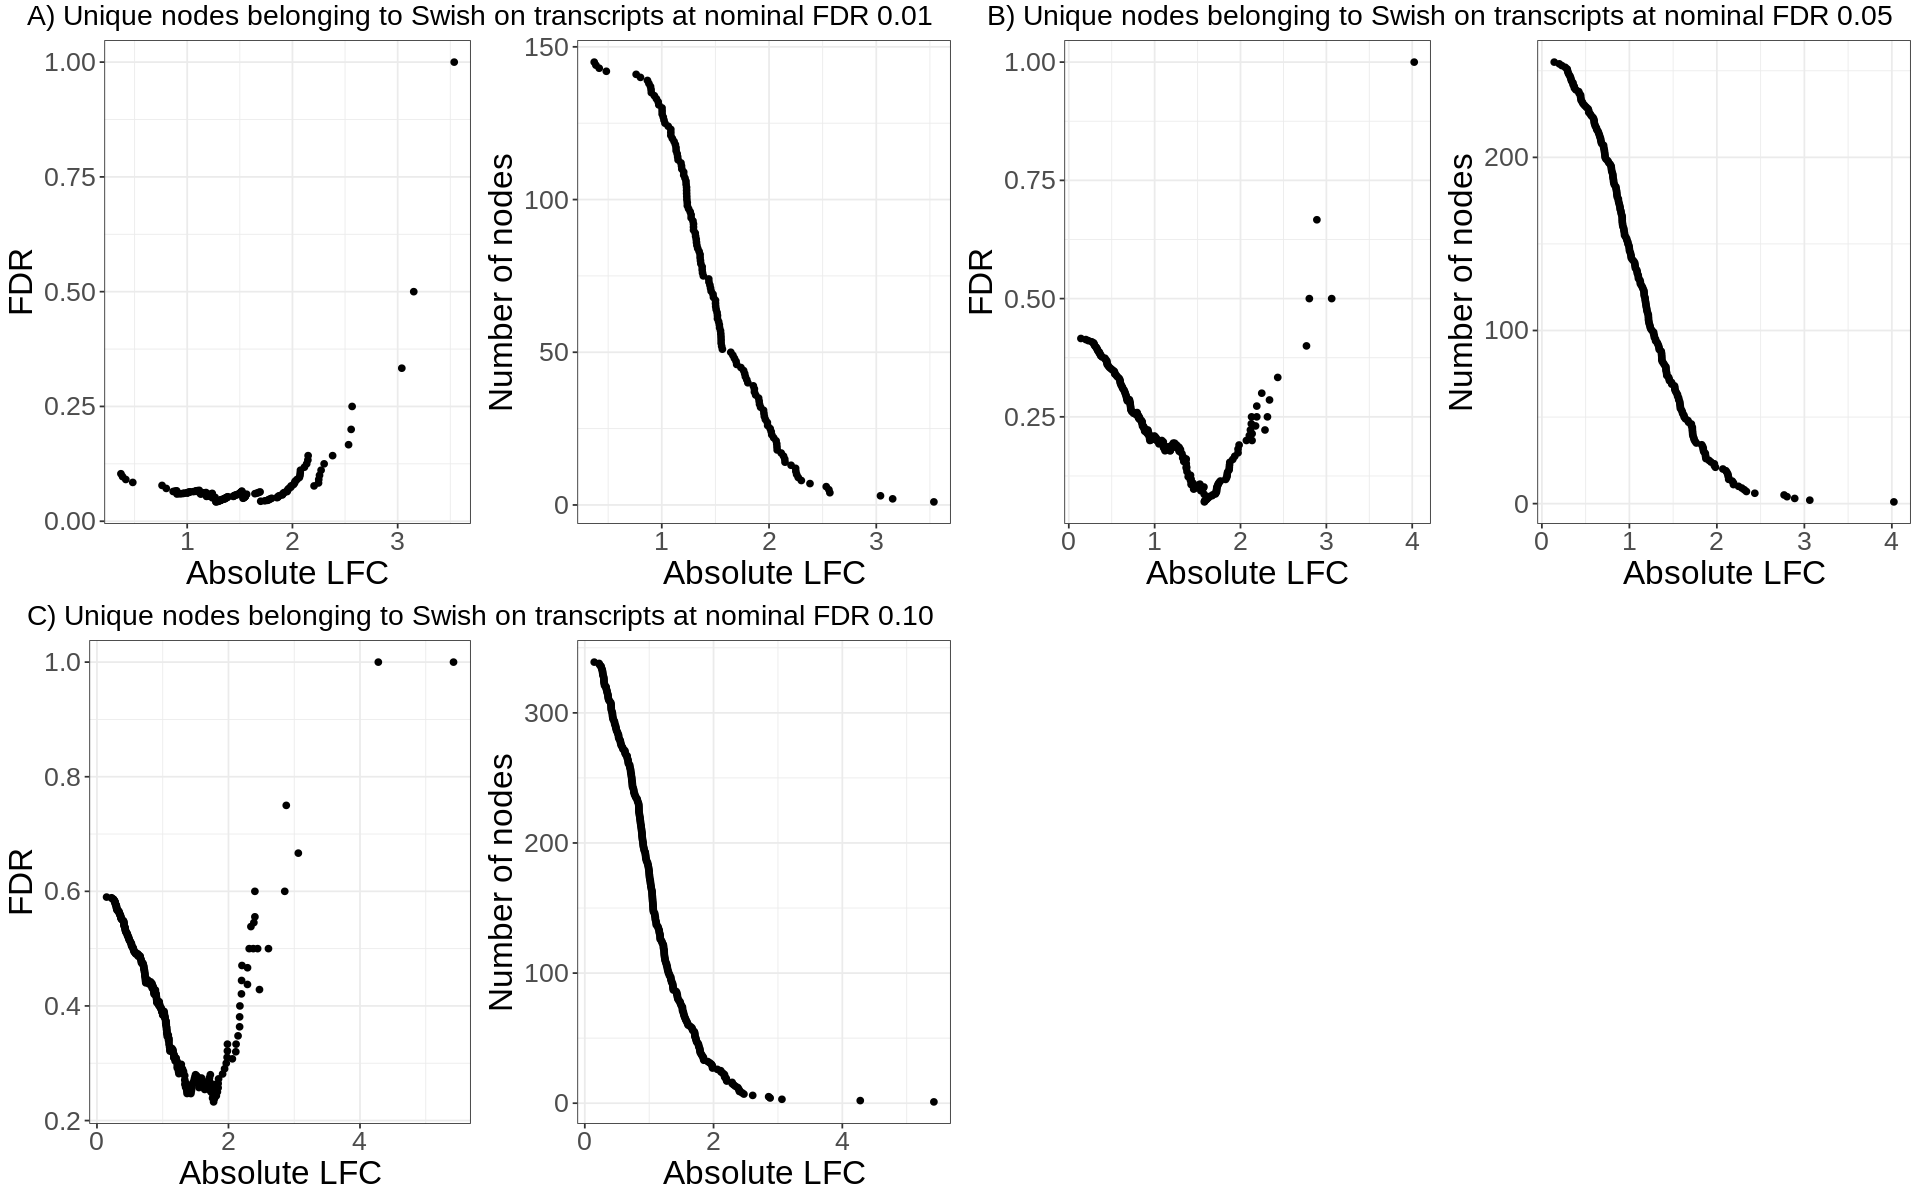

In [223]:
options(repr.plot.width=16, repr.plot.height=10)
p1 <- annotate_figure(plotScatPlot(vals$txp[[1]]), top=text_grob("A) Unique nodes belonging to Swish on transcripts at nominal FDR 0.01", size=17))
p2 <- annotate_figure(plotScatPlot(vals$txp[[2]]), top=text_grob("B) Unique nodes belonging to Swish on transcripts at nominal FDR 0.05", size=17))
p3 <- annotate_figure(plotScatPlot(vals$txp[[3]]), top=text_grob("C) Unique nodes belonging to Swish on transcripts at nominal FDR 0.10", size=17))
ggarrange(p1,p2,p3)